In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/MyDrive/CNN/data

Mounted at /content/drive
/content/drive/MyDrive/CNN/data


In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 32
# train_generator = ImageDataGenerator(rotation_range=45,
#                                      brightness_range=[0.3, 0.8],
#                                      width_shift_range=0.1,
#                                      height_shift_range=0.15,
#                                      horizontal_flip=True,
#                                      vertical_flip=True,
#                                      shear_range=20.0,
#                                      validation_split=0.30,
#                                      fill_mode='nearest',
#                                      featurewise_center=False,
#                                      samplewise_center=False,
#                                      preprocessing_function=preprocess_input)

train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data_dir = 'train'
test_data_dir = 'test'
validation_data_dir = 'validation'

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,
                                               #subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(validation_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=None,
                                               #subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = train_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
                                             classes=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5755 images belonging to 6 classes.
Found 1644 images belonging to 6 classes.
Found 827 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Reshape, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from keras import backend as K


def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)
    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(0.01))(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False, kernel_regularizer=l2(0.01))(se)
    x = multiply([init, se])
    return x

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg19 import preprocess_input
from keras.applications import ResNet152V2, MobileNetV2, ConvNeXtTiny
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization, Concatenate, GlobalAveragePooling2D
from pathlib import Path
import numpy as np

In [ ]:
def create_model(input_shape, input_layer, n_classes, optimizer='rmsprop', fine_tune=0):

  base_MobileNetV2 = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = input_shape)
  base_ResNet152V2 = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = input_shape)
  base_ConvNeXtTiny = ConvNeXtTiny(weights = 'imagenet', include_top = False, input_shape = input_shape)

  if fine_tune > 0:
    for layer in base_MobileNetV2.layers[:-fine_tune]:
      layer.trainable = False

    for layer in base_ResNet152V2.layers[:-fine_tune]:
      layer.trainable = False

    for layer in base_ConvNeXtTiny.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in base_MobileNetV2.layers:
      layer.trainable = False

    for layer in base_ResNet152V2.layers:
      layer.trainable = False

    for layer in base_ConvNeXtTiny.layers:
      layer.trainable = False

  model_MobileNetV2 = base_MobileNetV2(input_layer)
  # x1 = squeeze_excite_block(model_MobileNetV2)
  model_MobileNetV2 = GlobalAveragePooling2D()(model_MobileNetV2)
  output_MobileNetV2 = Flatten()(model_MobileNetV2)

  model_ResNet152V2 = base_ResNet152V2(input_layer)
  # x1 = squeeze_excite_block(model_ResNet152V2)
  model_ResNet152V2 = GlobalAveragePooling2D()(model_ResNet152V2)
  output_ResNet152V2 = Flatten()(model_ResNet152V2)

  model_ConvNeXtTiny = base_ConvNeXtTiny(input_layer)
  # x1 = squeeze_excite_block(model_ConvNeXtTiny)
  model_ConvNeXtTiny = GlobalAveragePooling2D()(model_ConvNeXtTiny)
  output_ConvNeXtTiny = Flatten()(model_ConvNeXtTiny)


  merged = Concatenate()([output_MobileNetV2, output_ResNet152V2, output_ConvNeXtTiny])

  x = BatchNormalization()(merged)
  x = Dense(256,activation = 'relu')(x)
  x = Dropout(0.4)(x)
  x = Dense(256,activation = 'relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128,activation = 'relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(64,activation = 'relu')(x)
  x = Dense(n_classes, activation = 'softmax')(x)

  stacked_model = Model(inputs = input_layer, outputs = x)
  optimizer = Adam(learning_rate=0.0001)
  stacked_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return stacked_model

In [ ]:
!pip install livelossplot --quiet

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='../stacked_model.hdf5',
                                  save_weights_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  save_best_only=True)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=50,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
input_layer = Input(shape = (224,224,3))
input_shape = (224, 224, 3)
n_classes=6

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

optimizer = Adam(learning_rate=0.0001)

stacked_model_ft = create_model(input_shape, input_layer, n_classes, optimizer, fine_tune=2)

111650432/111650432 [==============================] - 1s 0us/step


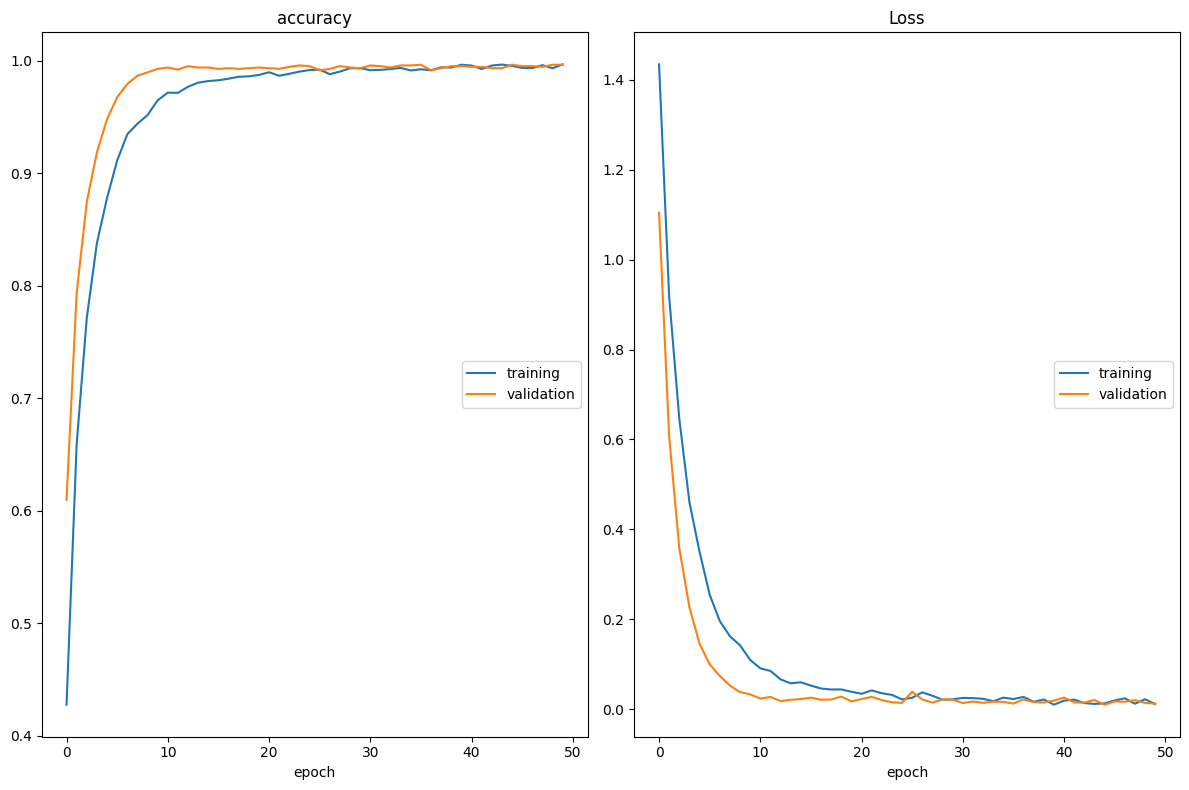

accuracy
	training         	 (min:    0.428, max:    0.997, cur:    0.997)
	validation       	 (min:    0.610, max:    0.996, cur:    0.996)
Loss
	training         	 (min:    0.010, max:    1.435, cur:    0.011)
	validation       	 (min:    0.010, max:    1.104, cur:    0.012)
179/179 [==============================] - 138s 769ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.0122 - val_accuracy: 0.9963


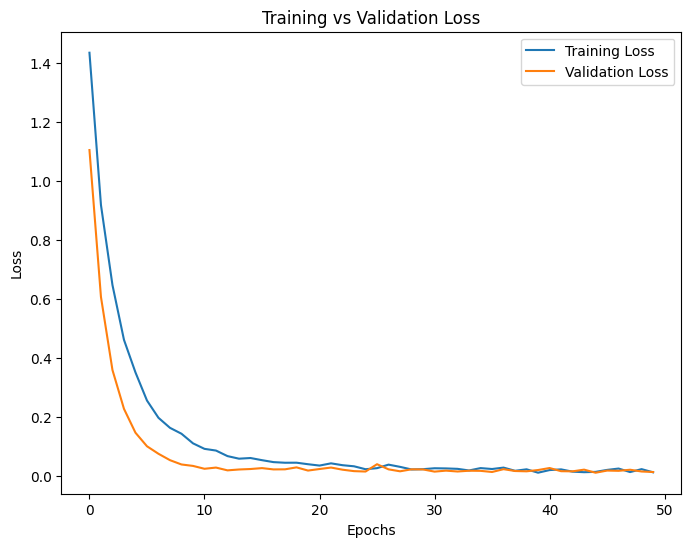

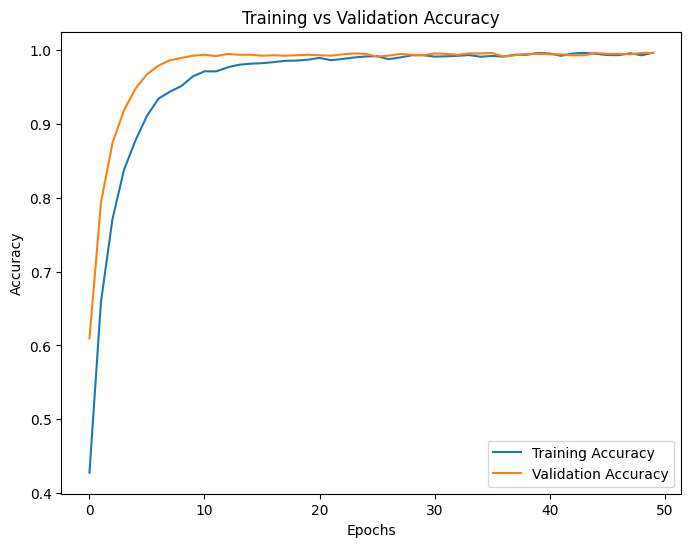

CPU times: user 1h 4min 58s, sys: 7min 9s, total: 1h 12min 7s
Wall time: 2h 32min 1s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

stacked_model_ft_history = stacked_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

# After training is completed, save the final training vs validation curve as a PDF
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(stacked_model_ft_history.history['loss'], label='Training Loss')
plt.plot(stacked_model_ft_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../training_validation_loss_curve.pdf')
plt.show()


# Plotting Training vs Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(stacked_model_ft_history.history['accuracy'], label='Training Accuracy')
plt.plot(stacked_model_ft_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../training_validation_accuracy_curve.pdf')
plt.show()


In [ ]:
# Generate predictions
# stacked_model_ft.load_weights('../stacked_model.hdf5')

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

stacked_model_preds_ft = stacked_model_ft.predict(testgen)
stacked_model_pred_classes_ft = np.argmax(stacked_model_preds_ft, axis=1)

827/827 [==============================] - 264s 309ms/step


In [ ]:
from sklearn.metrics import accuracy_score

stacked_model_accuracy = accuracy_score(true_classes, stacked_model_pred_classes_ft)
print("Predicted/Test Accuracy: {:.2f}%".format(stacked_model_accuracy * 100))

Predicted/Test Accuracy: 99.15%


# Classification Report

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have true labels (y_true) and predicted labels (y_pred)
y_true = true_classes # Example true labels
y_pred = stacked_model_pred_classes_ft  # Example predicted labels

# Get report with class names
class_names = ["Athracnose", "Blank Canker", "Diplodia Rot", "Leaf spot on fruit", "Leaf spot on Leaves", "Mealy Bug"]
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report of this stacked model: \n")
print(report)


Classification Report of this stacked model: 

                     precision    recall  f1-score   support

         Athracnose       0.98      0.96      0.97       108
       Blank Canker       0.99      1.00      1.00       178
       Diplodia Rot       0.98      1.00      0.99       165
 Leaf spot on fruit       1.00      1.00      1.00       126
Leaf spot on Leaves       1.00      0.99      0.99        88
          Mealy Bug       0.99      0.99      0.99       162

           accuracy                           0.99       827
          macro avg       0.99      0.99      0.99       827
       weighted avg       0.99      0.99      0.99       827



In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_confusion_matrix2(y_true, y_pred):
    """Plots a confusion matrix with class names and integer values.

    Args:
        y_true (np.ndarray): True class labels.
        y_pred (np.ndarray): Predicted class labels.
    """

    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt="d", ax=ax)

    # Set class names as tick labels
    class_names = ["Athracnose", "Blank Canker", "Diplodia Rot", "Leaf spot on fruit", "Leaf spot on Leaves", "Mealy Bug"]
    ax.set_xticks(np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha="right")

    # Set title and labels
    # ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    plt.tight_layout()
    plt.savefig("../ConfusionMatrix.pdf", bbox_inches='tight')
    plt.show()


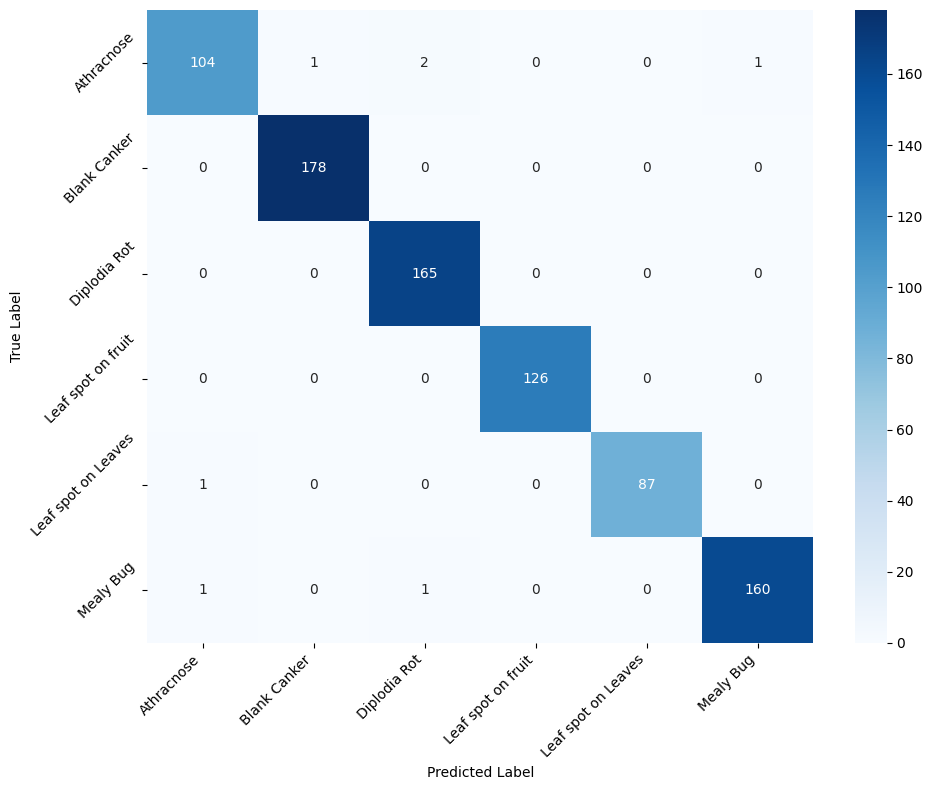

In [ ]:
plot_confusion_matrix2(true_classes, stacked_model_pred_classes_ft)

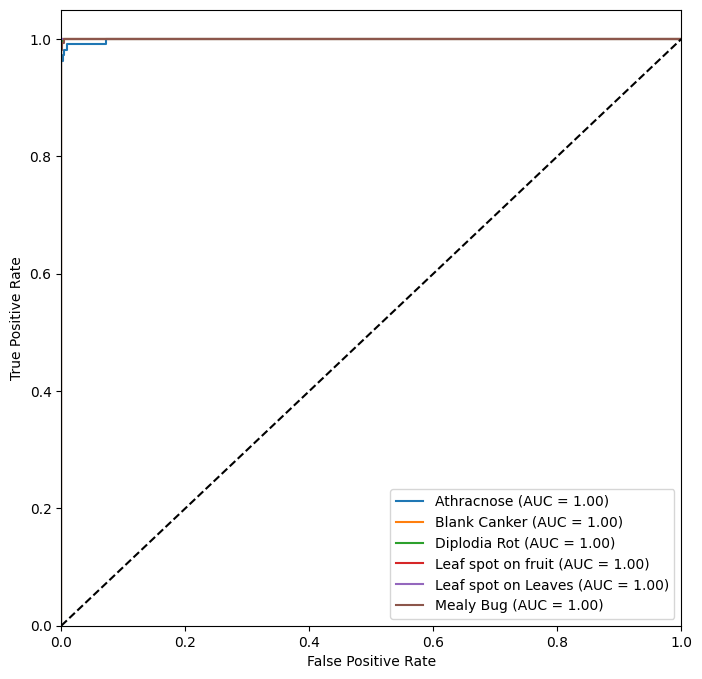

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Assuming you have your true labels (y_true) and predicted probabilities (y_pred_proba)
y_true = true_classes
y_pred_proba = stacked_model_preds_ft  # Example predicted probabilities (replace with your actual data)

# Class names
class_names = ["Athracnose", "Blank Canker", "Diplodia Rot", "Leaf spot on fruit", "Leaf spot on Leaves", "Mealy Bug"]

# Calculate ROC curves and AUC scores for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(6):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_true == i, y_pred_proba[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(8, 8))

for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curves for All Classes')
plt.legend(loc="lower right")
plt.savefig("../ROC_curve.pdf", bbox_inches='tight')
plt.show()
